# Generative Adversarial Networks

## Import the necessary libraries

In [129]:
import tensorflow as tf
import os
import time
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, Flatten, Dense, Reshape, Conv2DTranspose, Dropout, ReLU, Input, Concatenate, ZeroPadding2D, concatenate
from tensorflow.keras import Sequential, Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

## Load the dataset

In [130]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [131]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = np.pad(train_images, ((0,0), (2,2), (2,2), (0,0)), 'constant')

test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')
test_images = np.pad(test_images, ((0,0), (2,2), (2,2), (0,0)), 'constant')

## Define the plotting function

In [132]:
def plot_images(original, noisy, denoised=None, title=None, cmap="Greys"):
    """
    Plots original, noisy, and optionally denoised images in a grid.
    """
    num_images = 5
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        # Plot original images
        plt.subplot(3 if denoised is not None else 2, num_images, i + 1)
        plt.imshow(original[i], cmap=cmap)
        plt.title("Original")
        plt.axis("off")

        # Plot noisy images
        plt.subplot(3 if denoised is not None else 2, num_images, i + 1 + num_images)
        plt.imshow(noisy[i], cmap=cmap)
        plt.title("Noisy")
        plt.axis("off")

        # Plot denoised images (if provided)
        if denoised is not None:
            plt.subplot(3, num_images, i + 1 + 2 * num_images)
            plt.imshow(denoised[i], cmap=cmap)
            plt.title("Denoised")
            plt.axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

## Create noisy images

In [133]:
train_noisy_images = train_images.copy()
test_noisy_images = test_images.copy()

inp = train_images[0]
re = test_images[0]
VARIANCE = 30
for i in range(0, train_images.shape[0]):
    mean = 0
    gauss = np.random.normal(mean, VARIANCE, train_noisy_images[i].shape)
    train_noisy_images[i] += gauss
    train_noisy_images[i] = np.clip(train_noisy_images[i], 0, 255)
    
for i in range(0, test_noisy_images.shape[0]):
    mean = 0
    gauss = np.random.normal(mean, VARIANCE, test_noisy_images[i].shape)
    test_noisy_images[i] += gauss
    test_noisy_images[i] = np.clip(test_noisy_images[i], 0, 255)

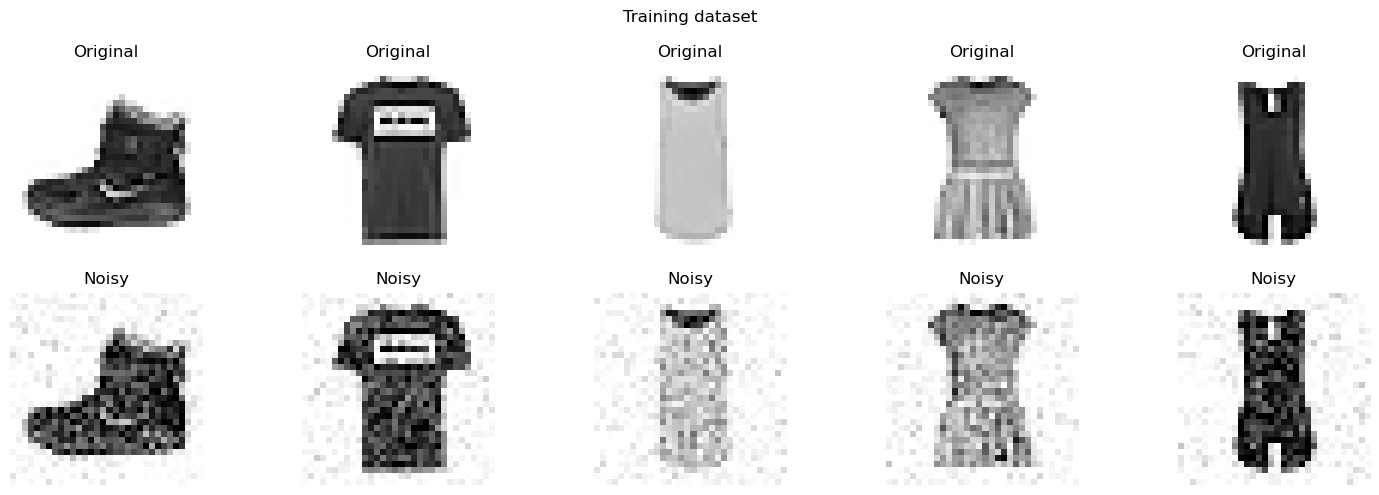

In [134]:
plot_images(train_images, train_noisy_images, title="Training dataset")

## Define parameters and reshape images

In [135]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
IMG_WIDTH = 32
IMG_HEIGHT = 32

OUTPUT_CHANNELS = 1

In [136]:
train_noisy_images = (train_noisy_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [137]:
test_images = (test_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
test_noisy_images = (test_noisy_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [138]:
train_images = tf.data.Dataset.from_tensor_slices((train_images, train_noisy_images)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [139]:
test_images = tf.data.Dataset.from_tensor_slices((test_images, test_noisy_images)).batch(BATCH_SIZE)

## Build the Generator

In [140]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = Sequential()
    result.add(
      Conv2D(
          filters, size, strides=2, padding='same',
          kernel_initializer=initializer, use_bias=False
      )
    )
    
    if apply_batchnorm:
        result.add(BatchNormalization())
    
    result.add(LeakyReLU())
    
    return result

In [141]:
down_model = downsample(1, 4)
down_result = down_model(tf.expand_dims(inp, 0))

In [142]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = Sequential()
    result.add(
        Conv2DTranspose(
            filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False
        )
    )
    
    result.add(BatchNormalization())
    
    if apply_dropout:
      result.add(Dropout(0.5))
    
    result.add(ReLU())
    
    return result

In [143]:
up_model = upsample(1, 4)
up_result = up_model(down_result)

In [144]:
def Generator():
    inputs = Input(shape=[32,32,1])
    
    down_stack = [
        downsample(16, 4, apply_batchnorm=False), # (bs, 16, 16, 16)
        downsample(32, 4), # (bs, 8, 8, 32)
        downsample(64, 4), # (bs, 4, 4, 64)
        downsample(64, 4), # (bs, 2, 2, 64)
        downsample(64, 4), # (bs, 1, 1, 64)
    ]
    
    up_stack = [
        upsample(64, 4, apply_dropout=True), # (bs, 2, 2, 128)
        upsample(64, 4, apply_dropout=True), # (bs, 4, 4, 128)
        upsample(32, 4), # (bs, 8, 8, 64)
        upsample(16, 4), # (bs, 16, 16, 32)
    ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = Conv2DTranspose(
        OUTPUT_CHANNELS, 4,
        strides=2,
        padding='same',
        kernel_initializer=initializer,
        activation='tanh'
    ) # (bs, 32, 32, 1)
    
    x = inputs
    
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])
    
    x = last(x)
    
    return Model(inputs=inputs, outputs=x)

In [145]:
generator = Generator()

## Define the Generator loss

In [146]:
LAMBDA = 100

In [147]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    
    # SSIM index 
    ssim = tf.reduce_mean(tf.image.ssim(gen_output, target, max_val=2))
    
    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    
    return total_gen_loss, gan_loss, l1_loss, ssim

## Build the Discriminator

In [148]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    
    inp = Input(shape=[32, 32, 1], name='input_image')
    tar = Input(shape=[32, 32, 1], name='target_image')
    
    x = concatenate([inp, tar]) # (bs, 32, 32, channels*2)
    
    down1 = downsample(16, 4, False)(x) # (bs, 16, 16, 16)
    down2 = downsample(32, 4)(down1) # (bs, 8, 8, 32)
    
    zero_pad1 = ZeroPadding2D()(down2) # (bs, 10, 10, 32)
    conv = Conv2D(
        32, 4, strides=1, kernel_initializer=initializer, use_bias=False
    )(zero_pad1) # (bs, 7, 7, 32)
    
    batchnorm1 = BatchNormalization()(conv)
    
    leaky_relu = LeakyReLU()(batchnorm1)
    
    zero_pad2 = ZeroPadding2D()(leaky_relu) # (bs, 9, 9, 32)
    
    last = Conv2D(
        1, 4, strides=1, kernel_initializer=initializer
    )(zero_pad2) # (bs, 6, 6, 1)
    
    return Model(inputs=[inp, tar], outputs=last)

In [149]:
discriminator = Discriminator()

## Define the Discriminator loss

In [150]:
loss_object = BinaryCrossentropy(from_logits=True)

In [151]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

## Define the Optimizers and Checkpoint-saver

In [152]:
generator_optimizer = Adam(2e-4, beta_1=0.5)
discriminator_optimizer = Adam(2e-4, beta_1=0.5)

In [153]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)

## Training

In [154]:
EPOCHS = 10

In [155]:
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        
        gen_total_loss, gen_gan_loss, gen_l1_loss, gen_ssim_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
        
        generator_gradients = gen_tape.gradient(gen_total_loss,
                                              generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss,
                                                   discriminator.trainable_variables)
        
        generator_optimizer.apply_gradients(zip(generator_gradients,
                                              generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                  discriminator.trainable_variables))
        
    return gen_total_loss, disc_loss

In [156]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()
        
        gen_loss_avg = tf.keras.metrics.Mean()
        disc_loss_avg = tf.keras.metrics.Mean()

        # Visualize results on the test dataset
        for example_target, example_input in test_ds.take(2):
            plot_images(example_target, example_input, generator(example_input, training=True), title="EPOCH: " + str(epoch + 1))

        print(f"Epoch {epoch + 1}/{epochs}")

        # Training loop
        for n, (target, input_image) in train_ds.enumerate():
            gen_loss, disc_loss = train_step(input_image, target)
            
            gen_loss_avg.update_state(gen_loss)
            disc_loss_avg.update_state(disc_loss)

            if (n + 1) % 100 == 0:
                print('.', end='')
        
        print()  # New line after progress bar

        print(f"Generator Loss: {gen_loss_avg.result().numpy():.4f}, Discriminator Loss: {disc_loss_avg.result().numpy():.4f}")
        print(f'Time taken for epoch {epoch + 1} is {time.time() - start} sec\n')

        checkpoint.save(file_prefix=checkpoint_prefix)

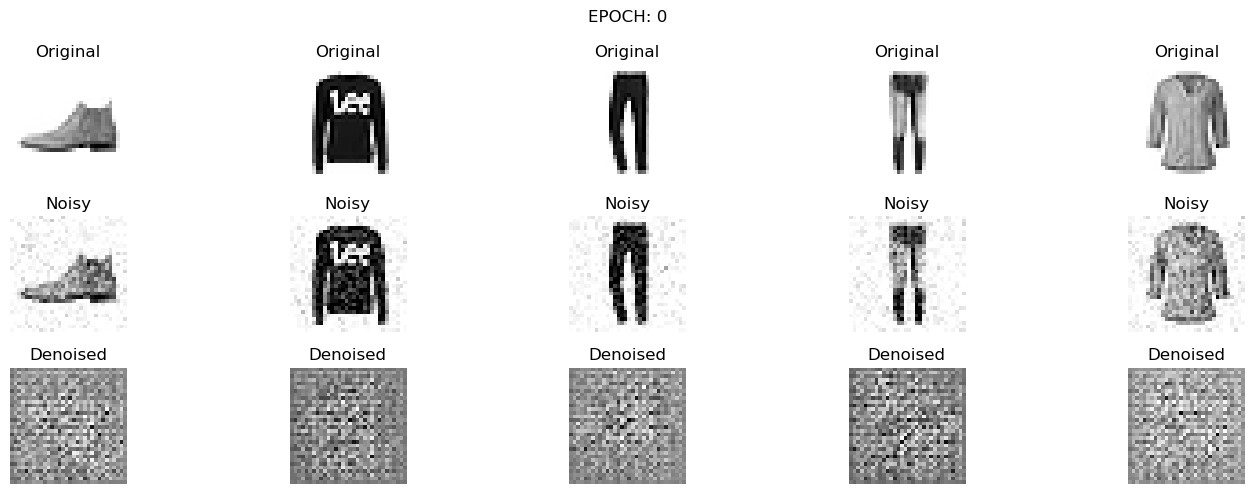

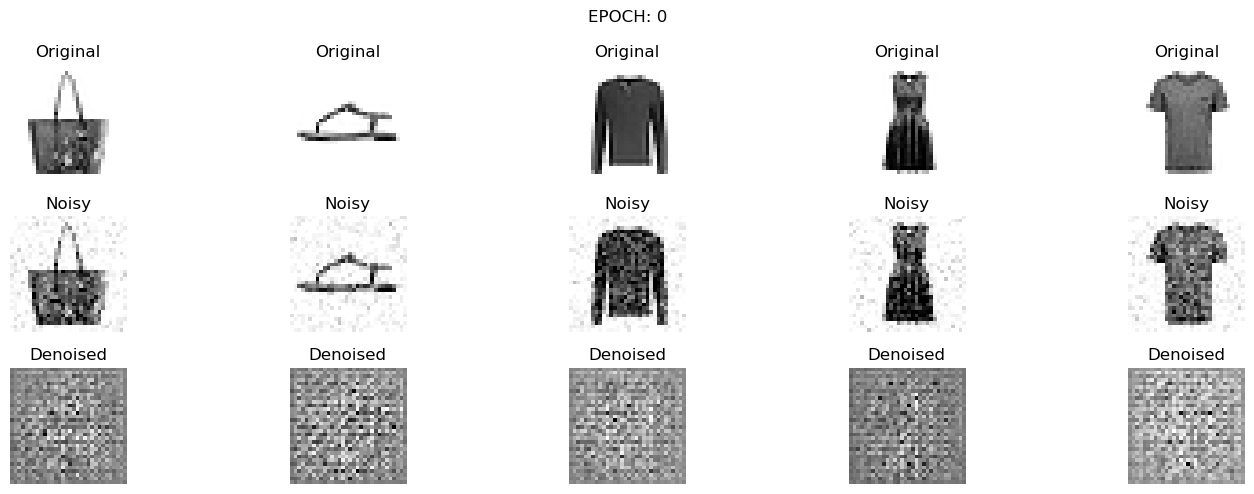

2025-01-10 23:32:24.442837: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/10
..
Generator Loss: 30.3107, Discriminator Loss: 0.4248
Time taken for epoch 1 is 26.62355899810791 sec



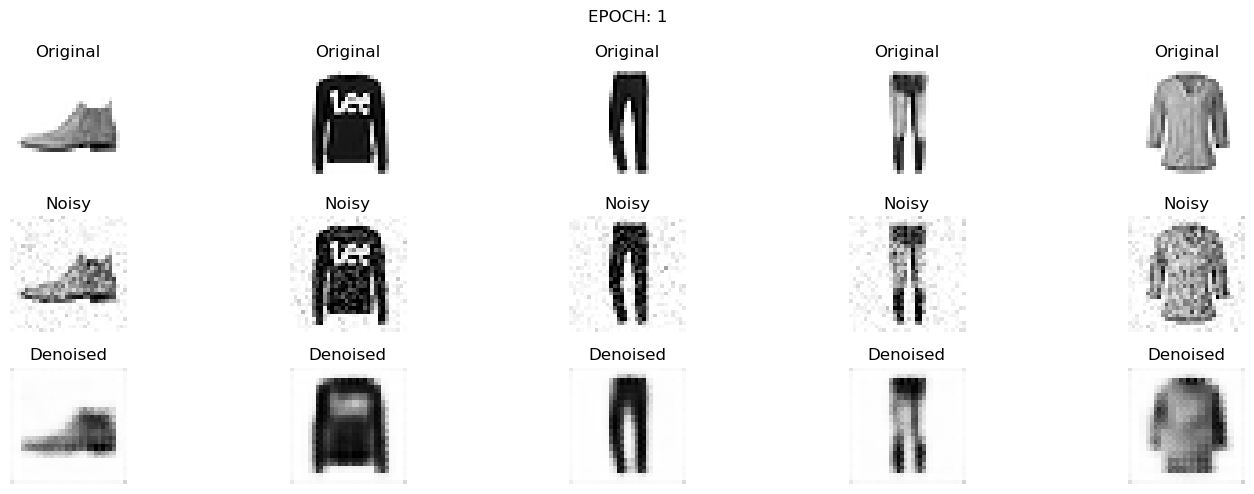

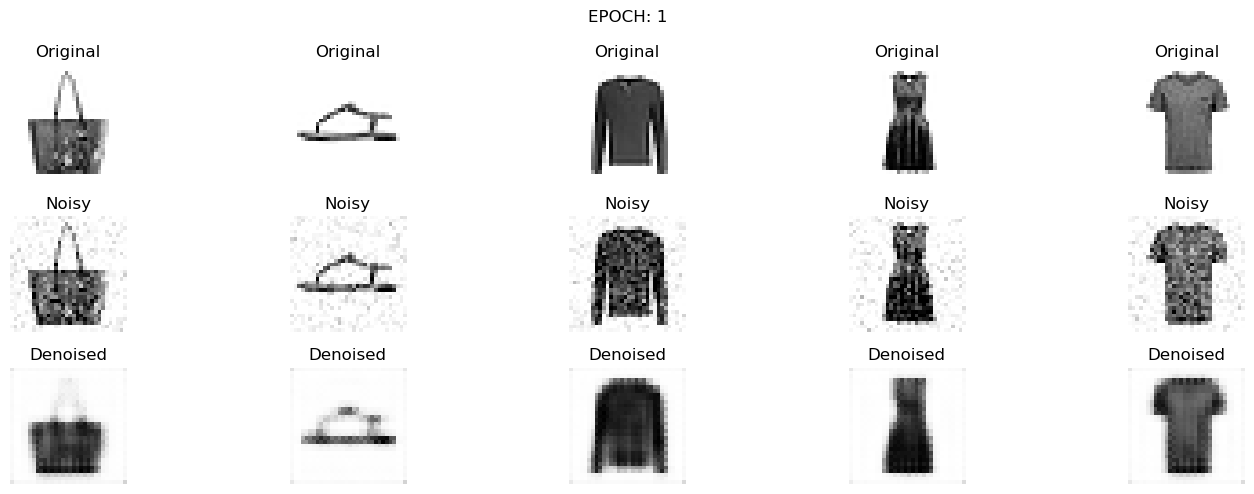

Epoch 2/10
..
Generator Loss: 11.4624, Discriminator Loss: 0.7126
Time taken for epoch 2 is 25.846329927444458 sec



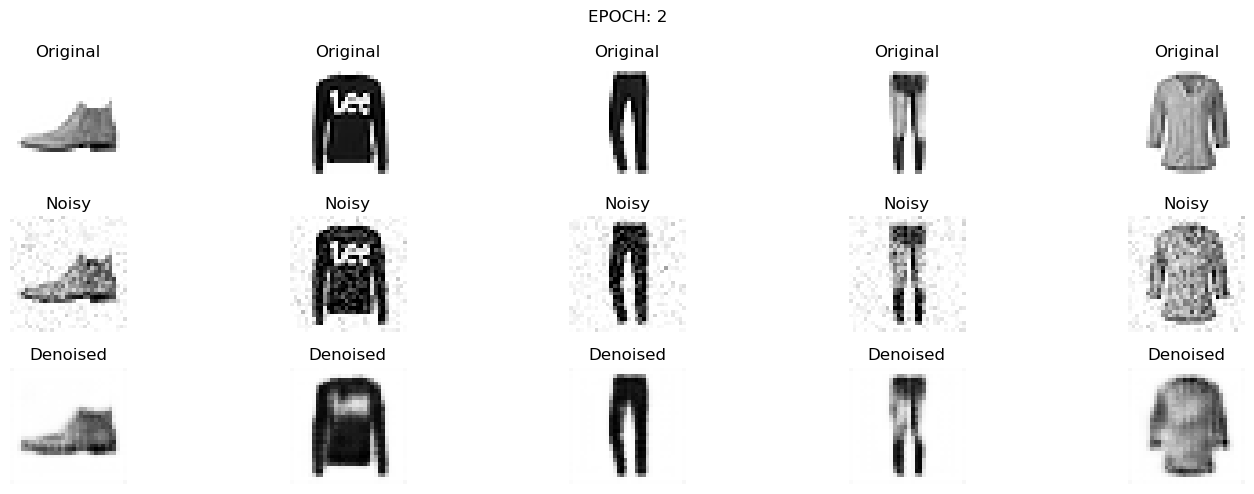

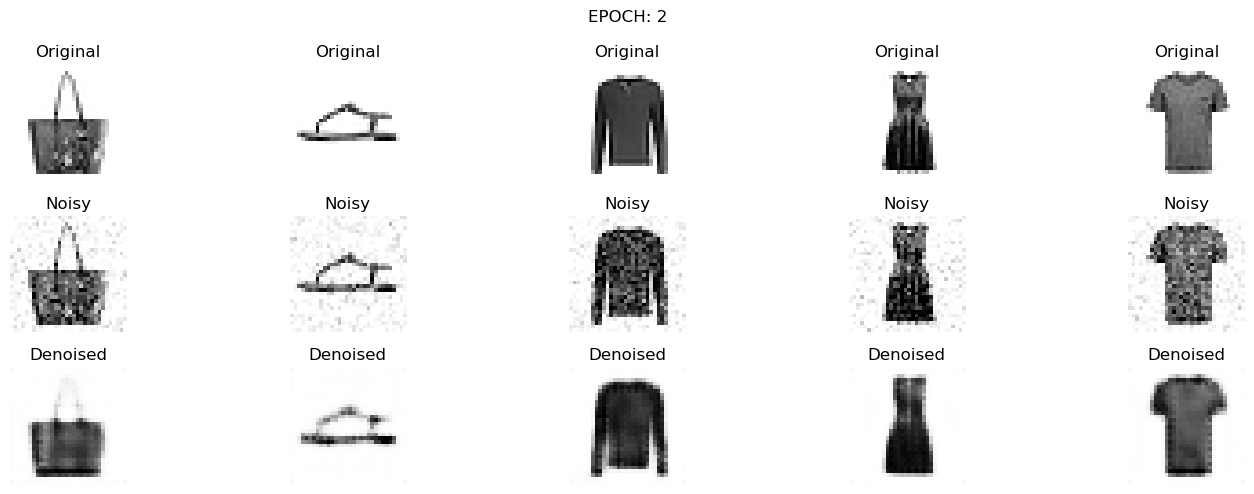

Epoch 3/10
..
Generator Loss: 8.7168, Discriminator Loss: 0.9159
Time taken for epoch 3 is 28.004239797592163 sec



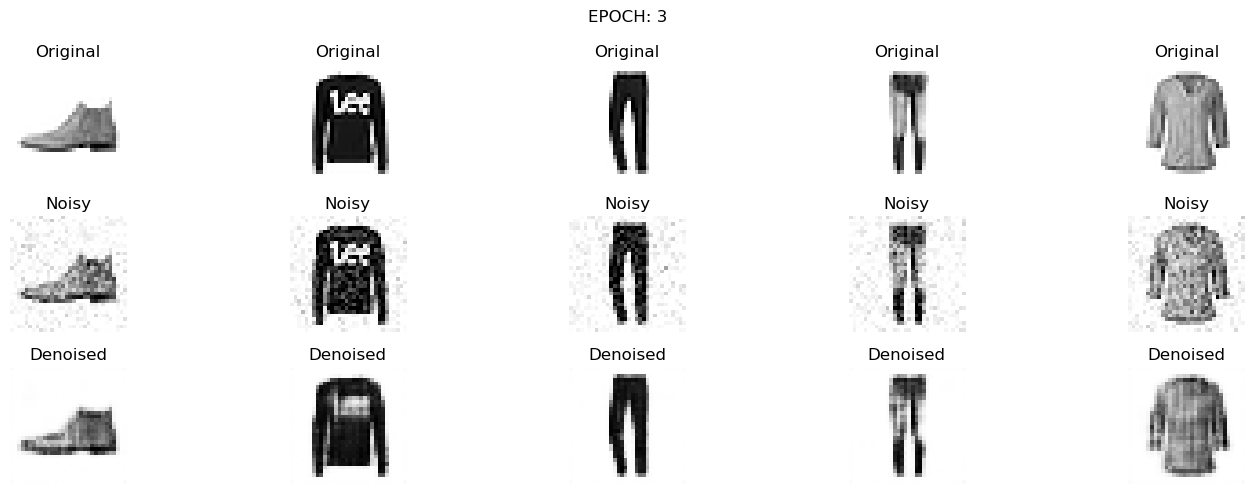

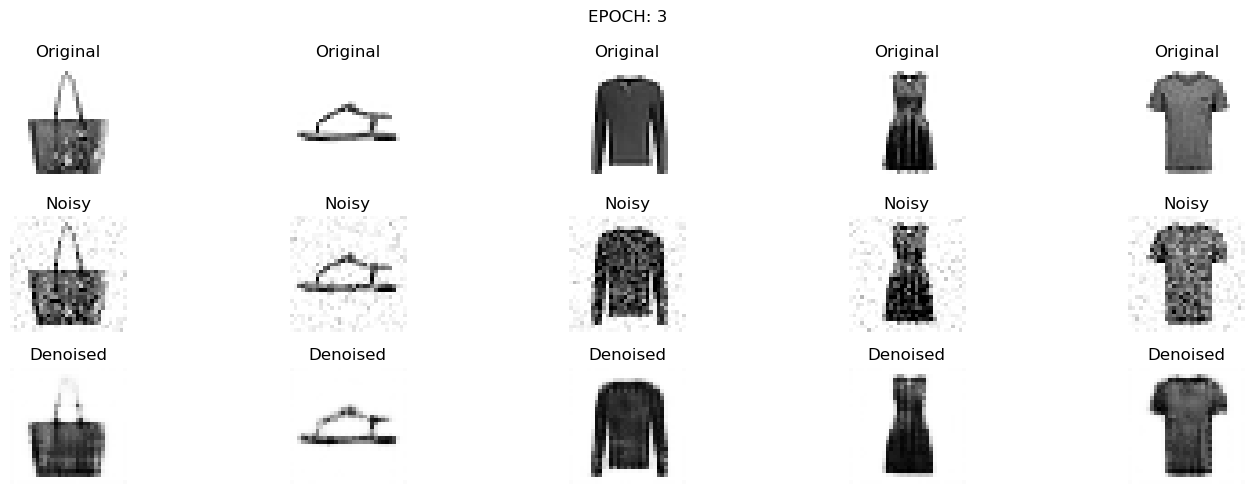

Epoch 4/10
..
Generator Loss: 7.6815, Discriminator Loss: 1.0233
Time taken for epoch 4 is 26.635733127593994 sec



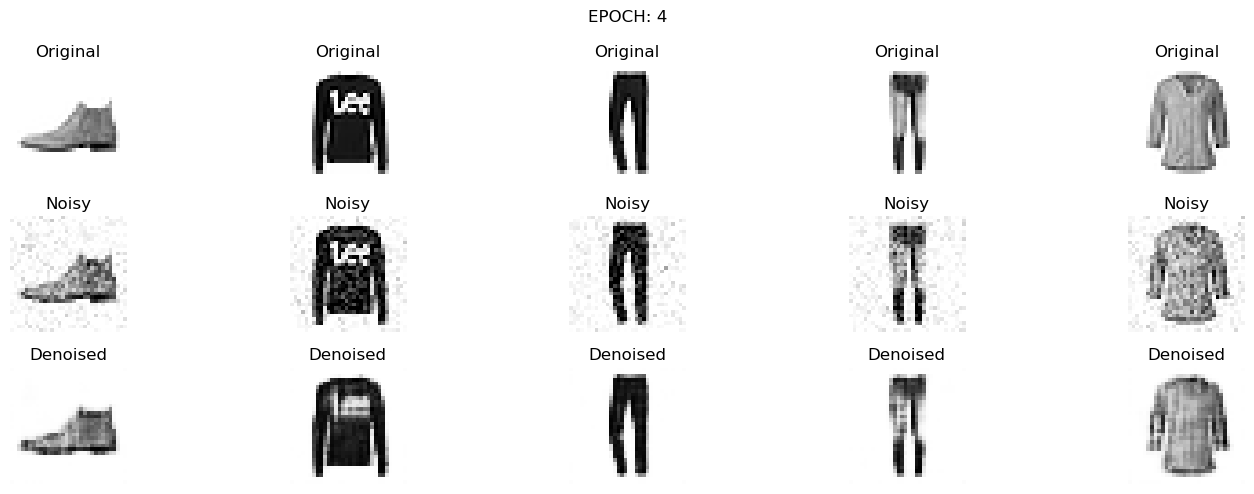

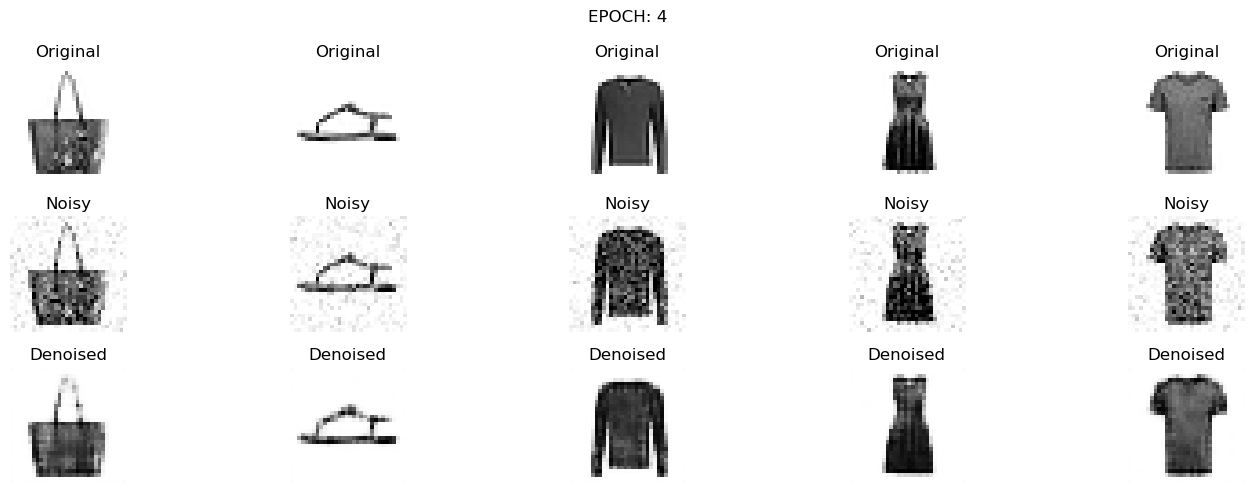

Epoch 5/10
..
Generator Loss: 7.2965, Discriminator Loss: 1.0246
Time taken for epoch 5 is 29.706315994262695 sec



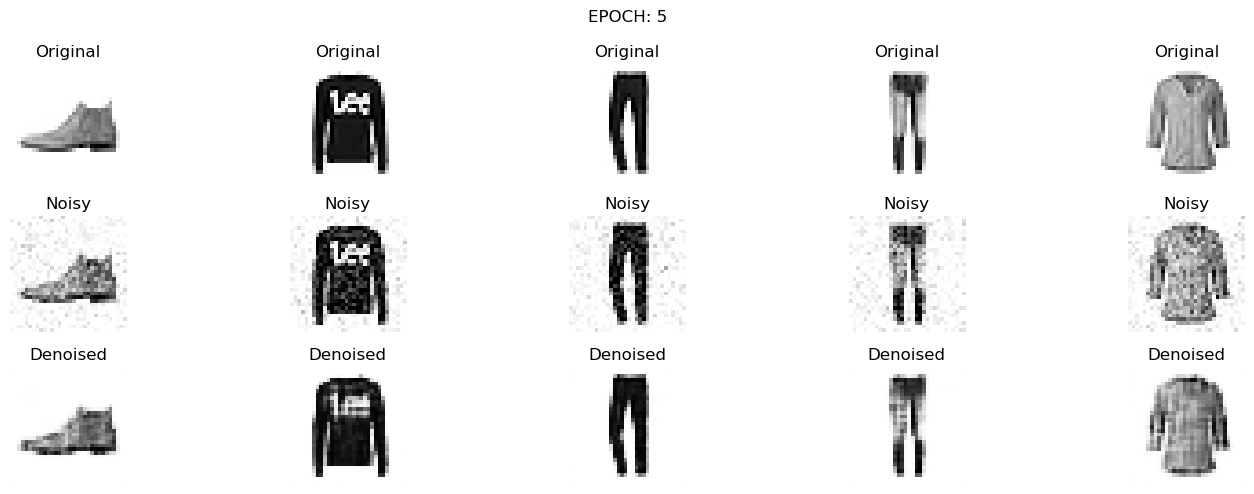

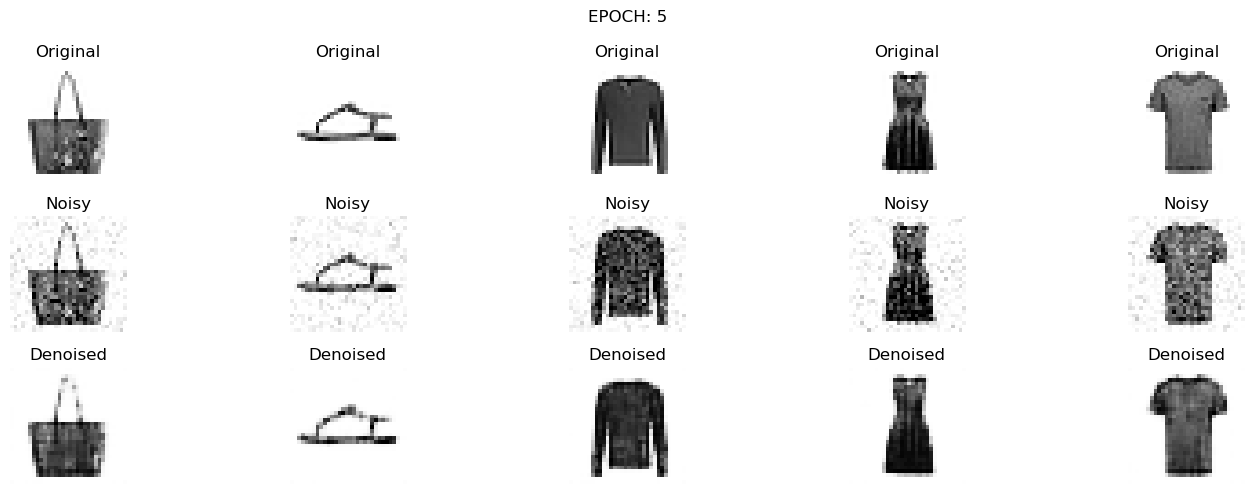

Epoch 6/10
..
Generator Loss: 7.1466, Discriminator Loss: 1.0402
Time taken for epoch 6 is 27.804166316986084 sec



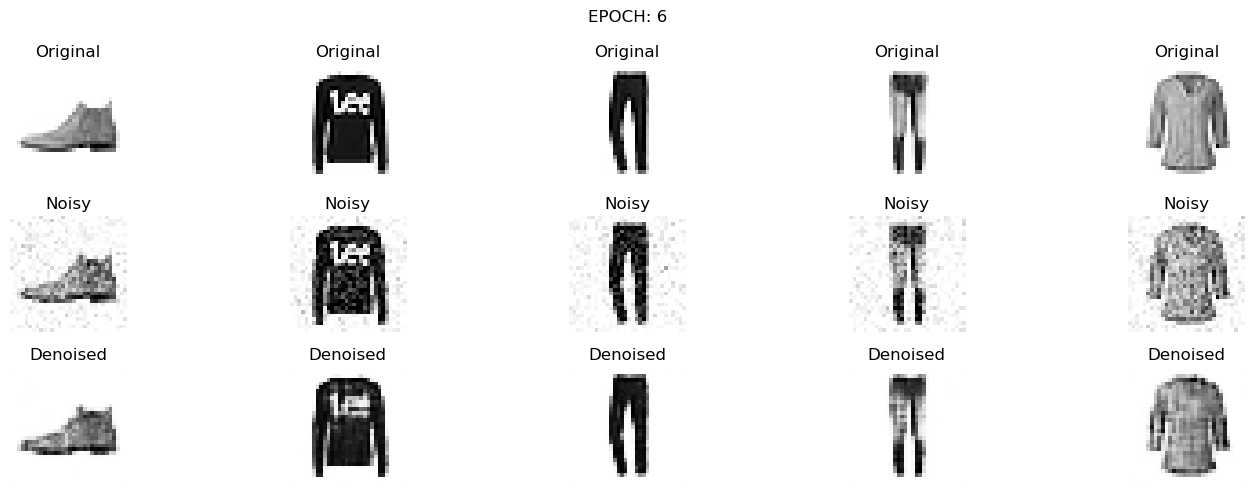

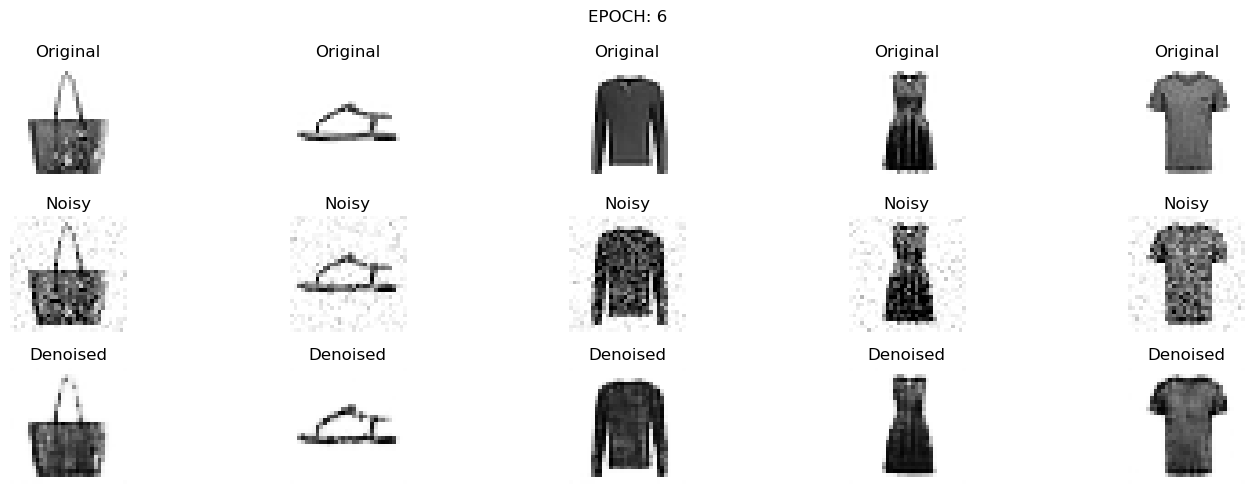

Epoch 7/10
..
Generator Loss: 6.9814, Discriminator Loss: 1.0648
Time taken for epoch 7 is 29.668535947799683 sec



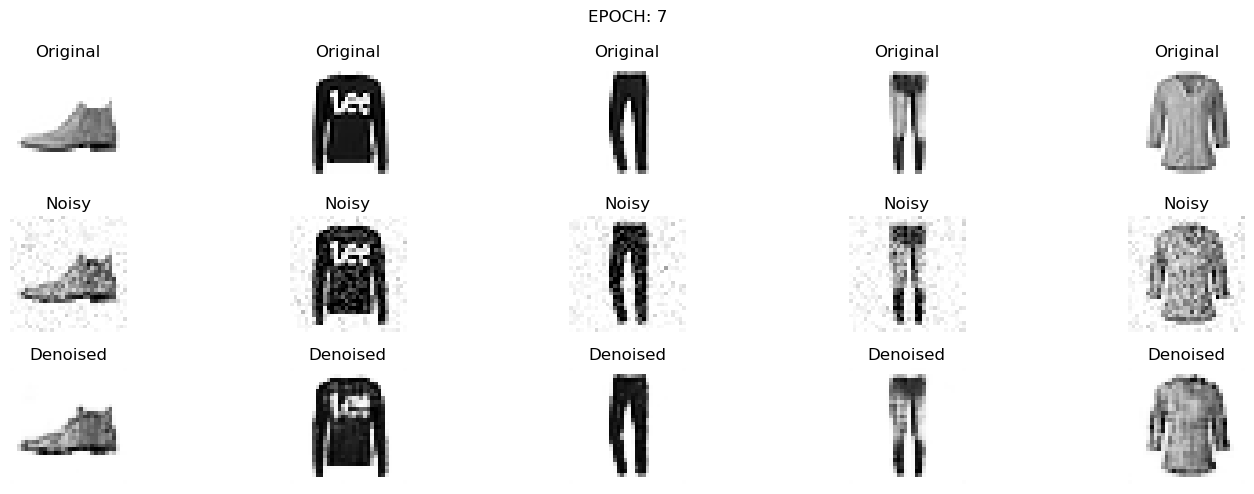

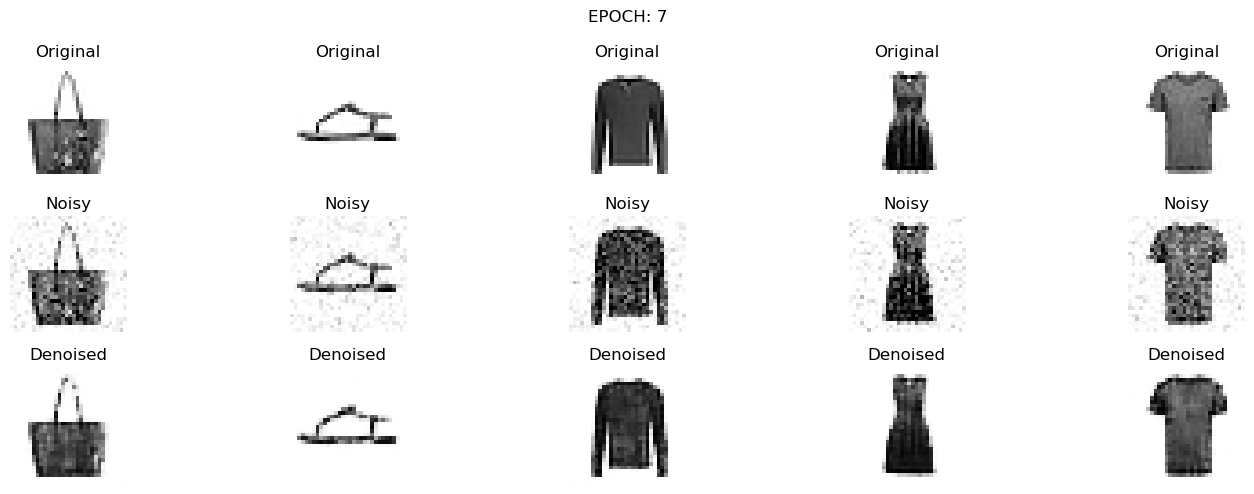

Epoch 8/10
..
Generator Loss: 6.8071, Discriminator Loss: 1.1477
Time taken for epoch 8 is 31.221436738967896 sec



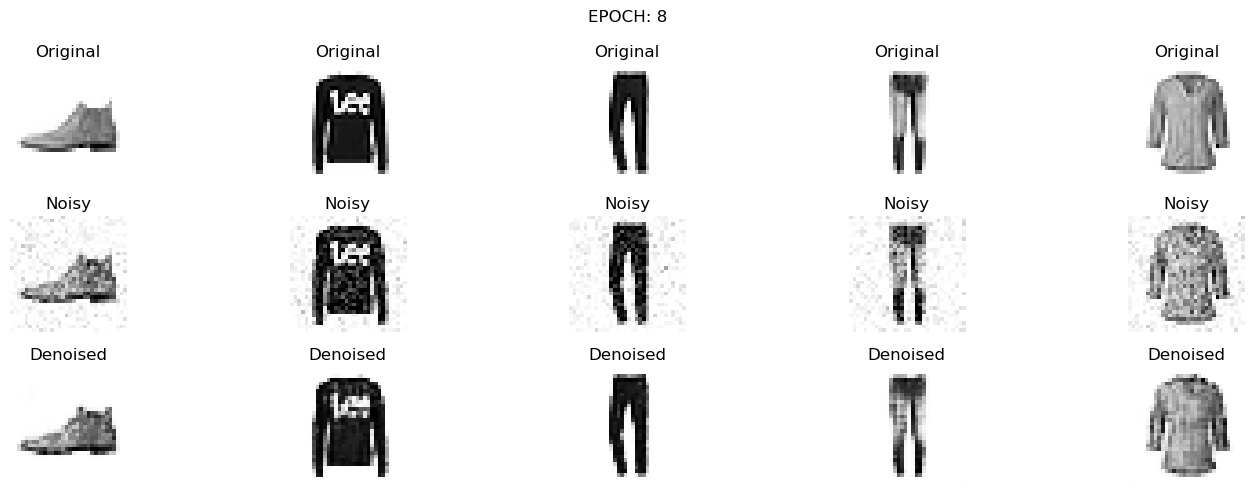

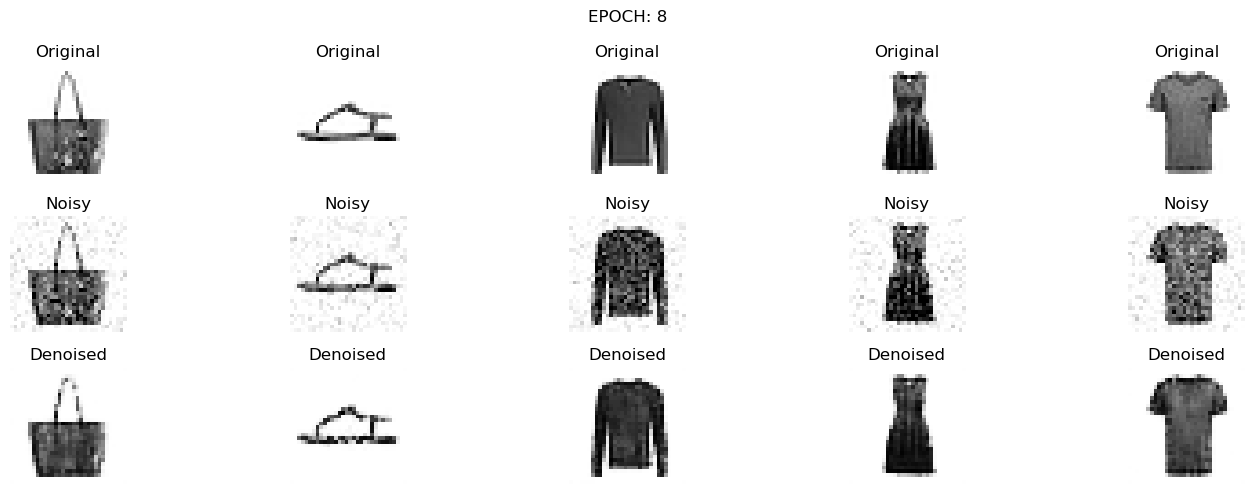

Epoch 9/10
..
Generator Loss: 6.6724, Discriminator Loss: 1.2217
Time taken for epoch 9 is 32.94420003890991 sec



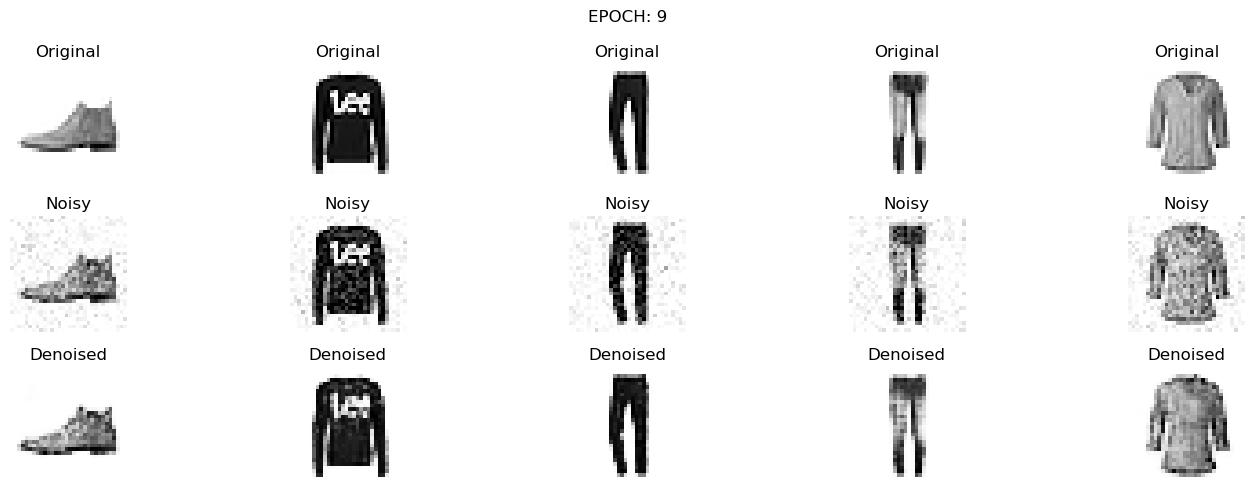

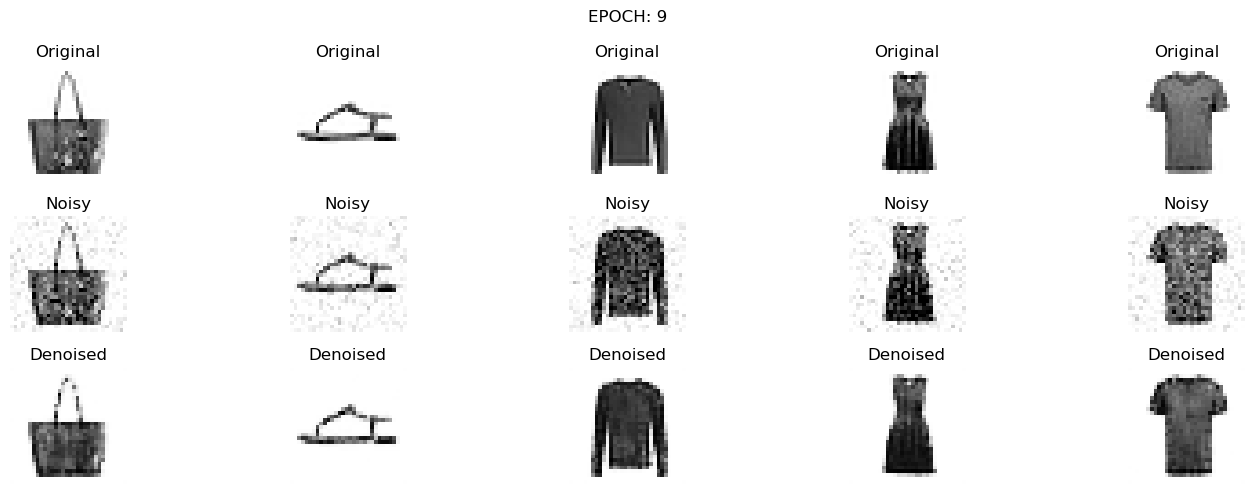

Epoch 10/10
..
Generator Loss: 6.5126, Discriminator Loss: 1.2467
Time taken for epoch 10 is 31.09756588935852 sec



In [157]:
fit(train_images, EPOCHS, test_images)

# Restore the latest checkpoint and test

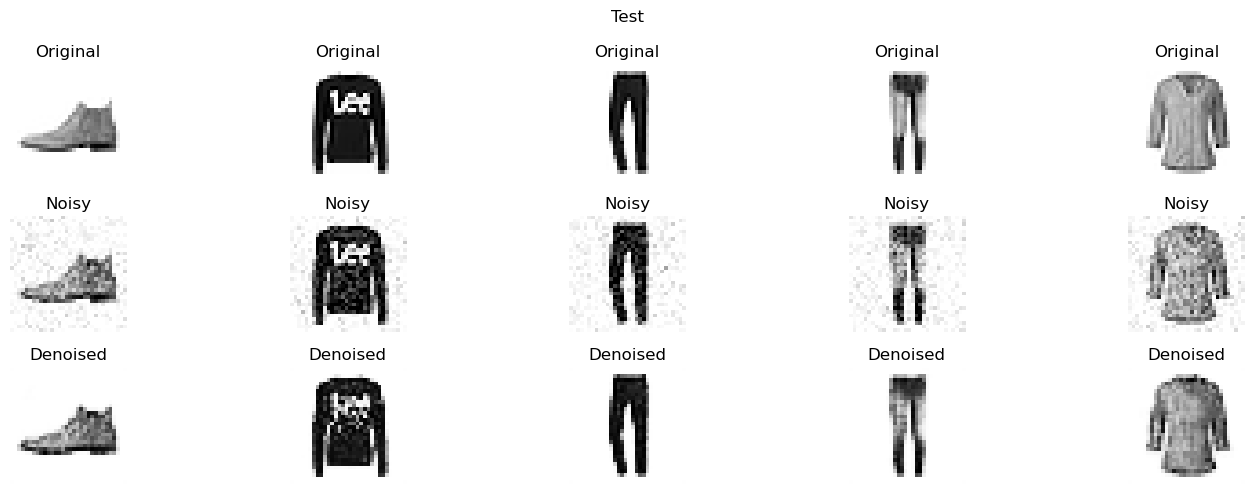

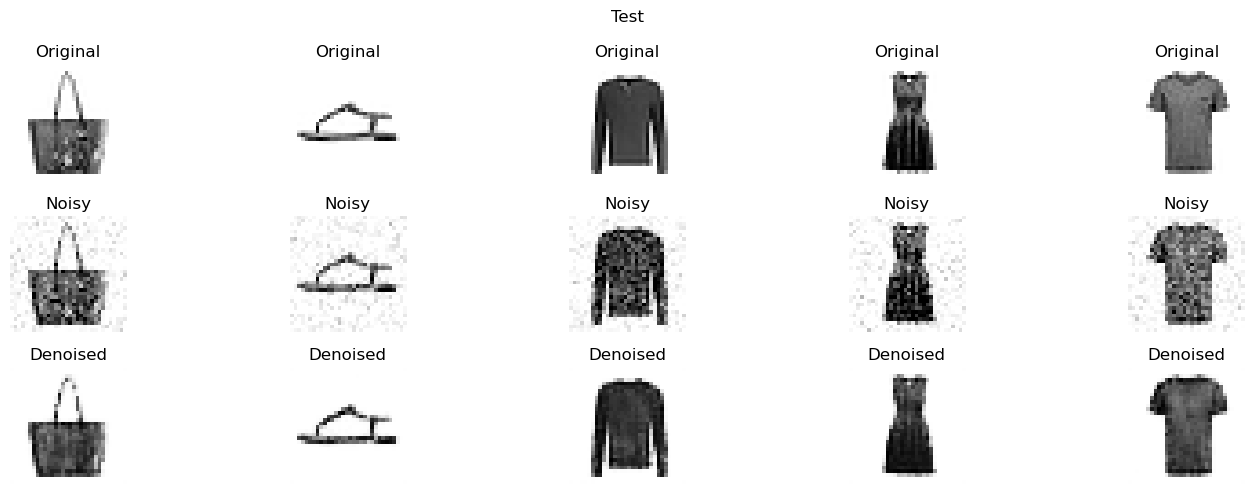

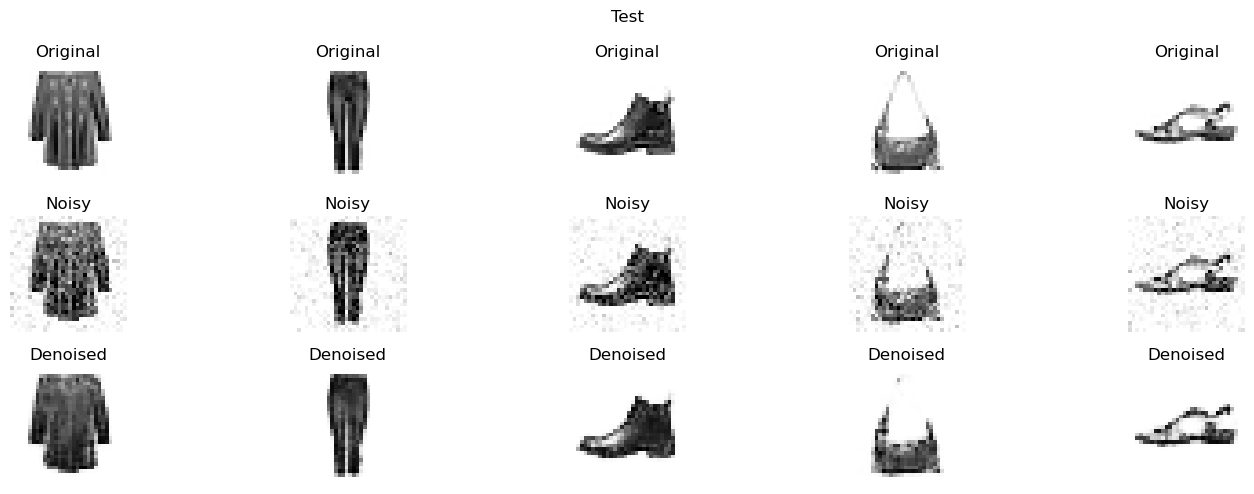

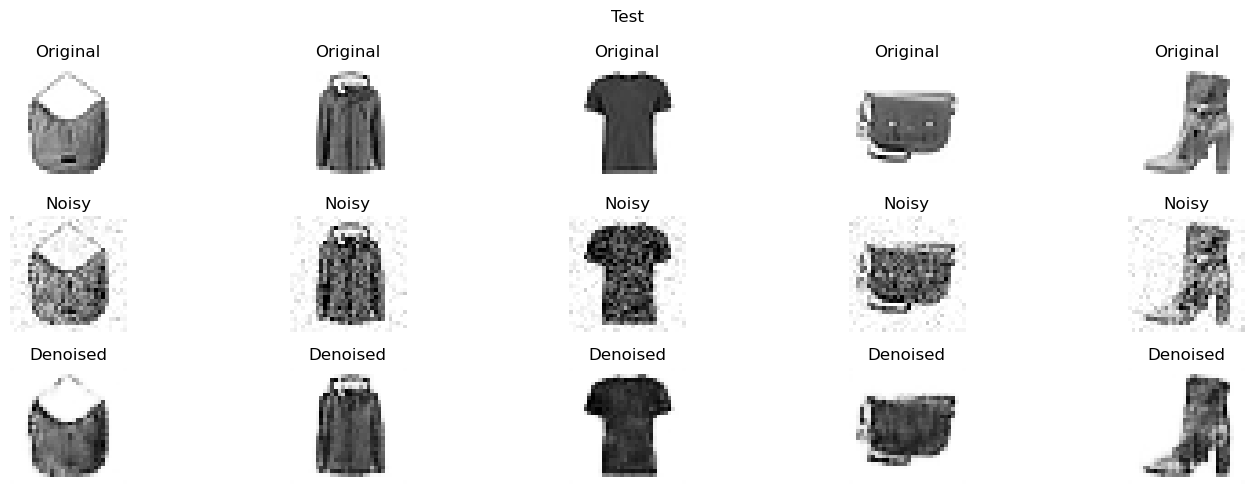

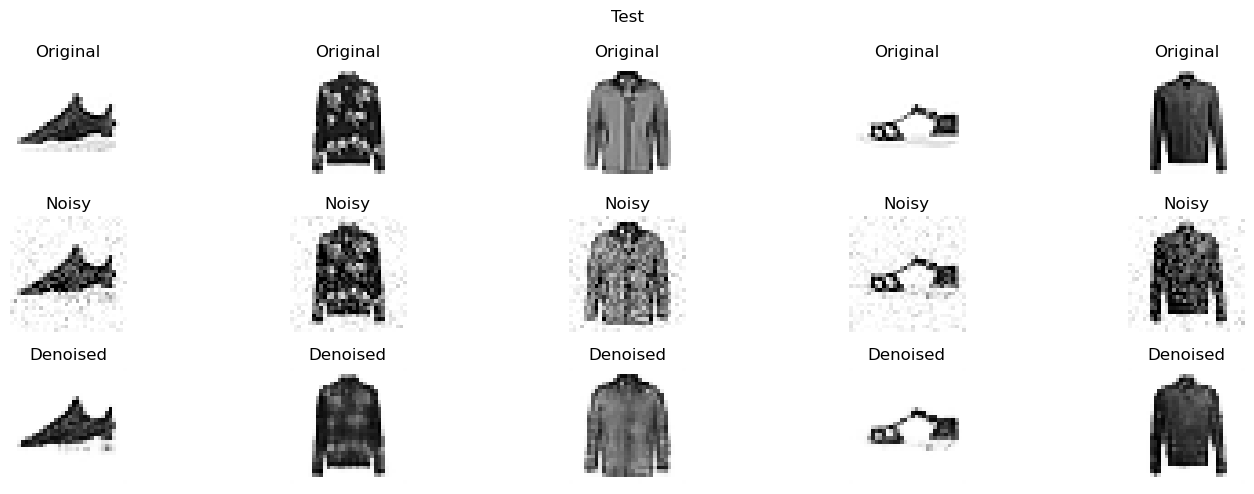

In [159]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

for tar, inp in test_images.take(5):
    plot_images(tar, inp, generator(inp, training=True), title="Test")